# Student Performance analysis and exam score prediction

In [323]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import catboost as cb

import xgboost as xgb


from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

sns.set_theme(style='whitegrid',font_scale=1.3, palette='Set2')
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


## Data Preparation and EDA

In [324]:
df = pd.read_csv("StudentPerformanceFactors.csv")
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


In [325]:
df.describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [326]:
df.duplicated().sum()

0

In [327]:
df.isna().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

In [328]:
df.dropna(inplace=True)

In [329]:
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


In [330]:
df.columns = [x.lower() for x in df.columns]

In [331]:
features = ['hours_studied', 'attendance', 'sleep_hours']

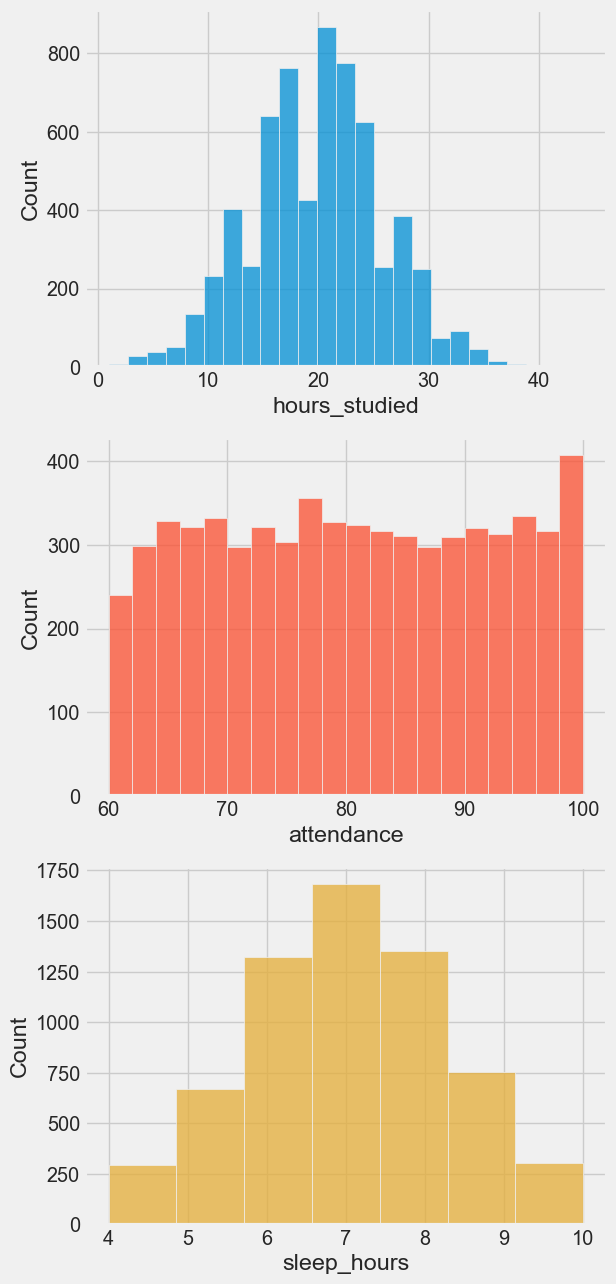

In [332]:
fig, axes = plt.subplots(3,1,figsize=(6,15))
sns.histplot(data=df,x=features[0], ax=axes[0],bins=25,color=color_pal[0])
sns.histplot(data=df,x=features[1], ax=axes[1],bins=20,color=color_pal[1])
sns.histplot(data=df,x=features[2], ax=axes[2],bins=7,color=color_pal[2])
plt.show()

<Axes: xlabel='exam_score', ylabel='Count'>

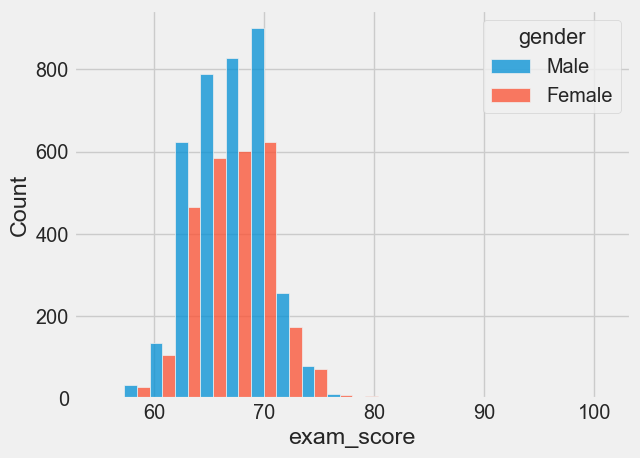

In [333]:
sns.histplot(data=df,x='exam_score',hue='gender',multiple='dodge',bins=20)

In [334]:
df

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


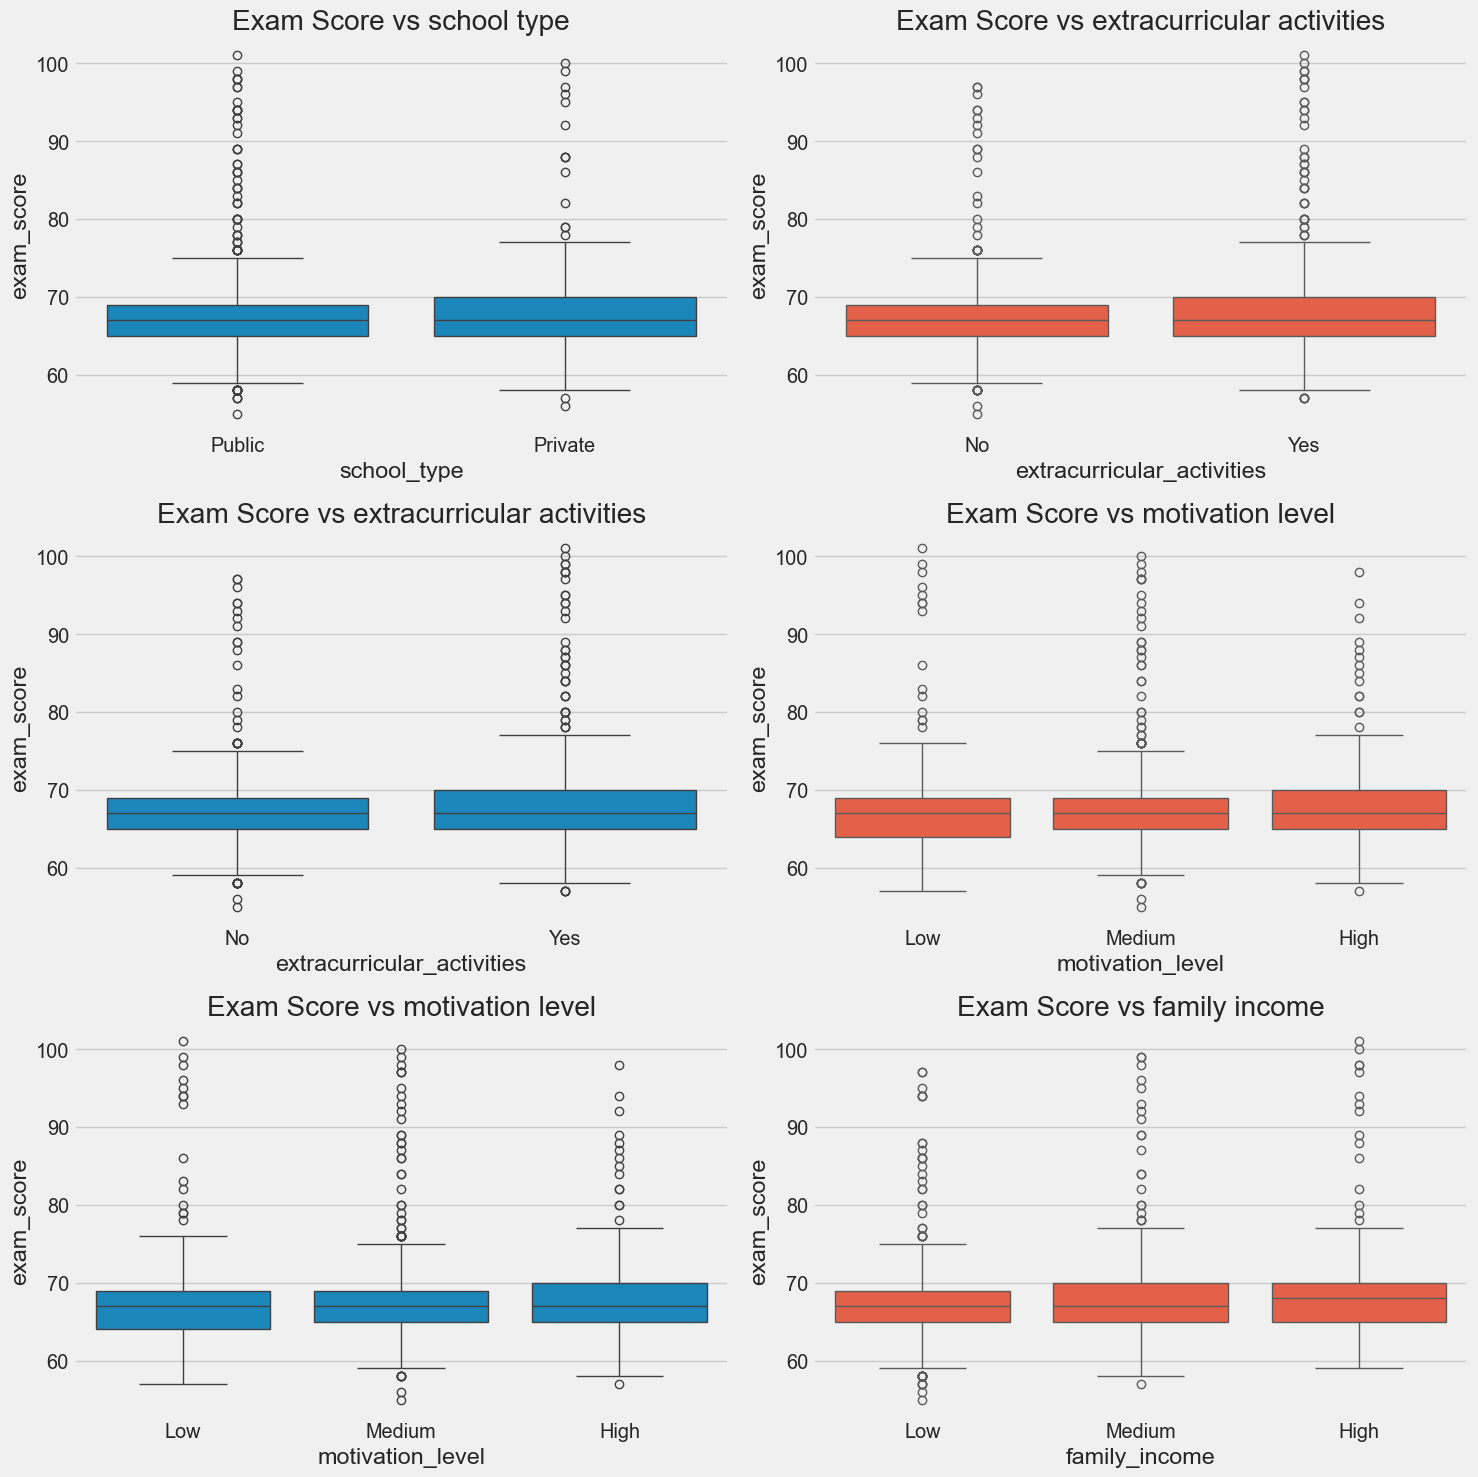

In [335]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
features = ['school_type','extracurricular_activities','motivation_level','family_income','teacher_quality','parental_education_Level']
for i in range(3):
    for j in range(2):
        sns.boxplot(x=features[i+j], y='exam_score', data=df, ax=axes[i, j],color=color_pal[j])
        axes[i, j].set_title('Exam Score vs {0}'.format(features[i+j].replace('_',' ')))

plt.tight_layout()
plt.show()

In [336]:


# Melakukan label encoding pada semua kolom dengan tipe data objek (string)
label_encoder = LabelEncoder()

for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# Menampilkan hasil encoding
df.head()

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,1,0,0,7,73,1,1,0,1,2,1,2,3,0,1,2,1,67
1,19,64,1,2,0,8,59,1,1,2,2,2,1,0,4,0,0,1,0,61
2,24,98,2,2,1,7,91,2,1,2,2,2,1,1,4,0,2,2,1,74
3,29,89,1,2,1,8,98,2,1,1,2,2,1,0,4,0,1,1,1,71
4,19,92,2,2,1,6,65,2,1,3,2,0,1,1,4,0,0,2,0,70


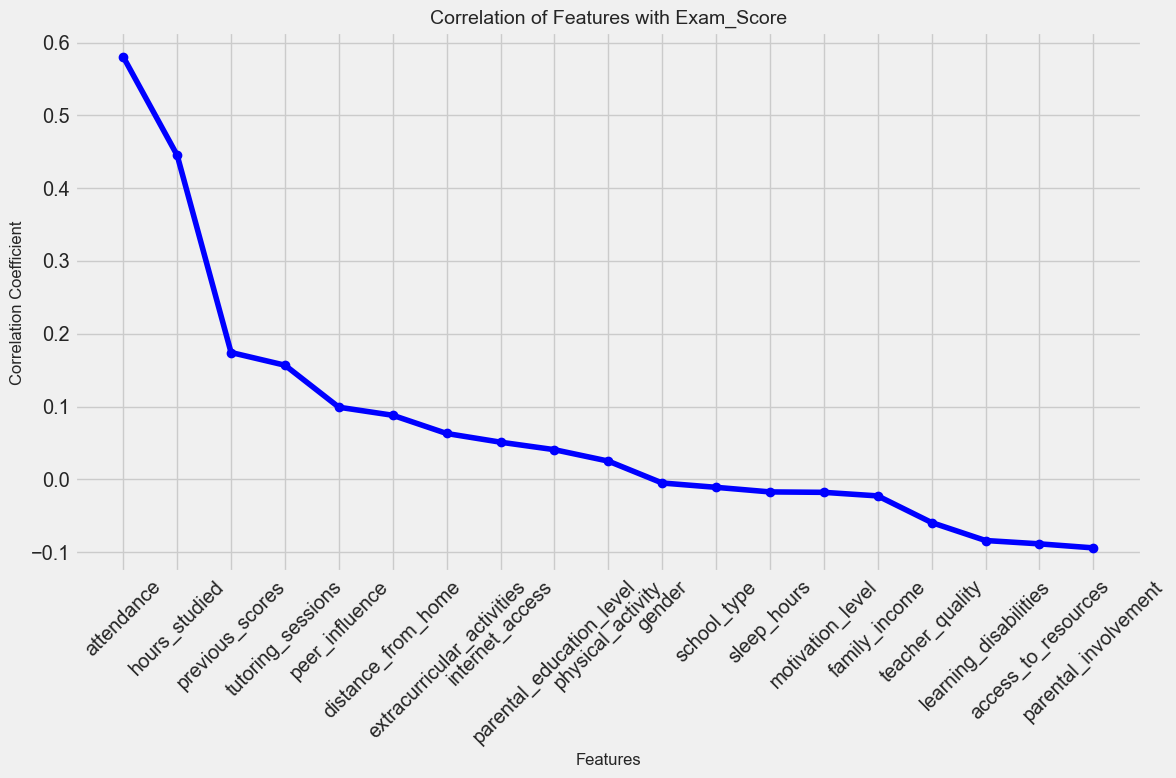

In [337]:
correlations = df.corr()['exam_score'].drop('exam_score')


sorted_correlations = correlations.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
plt.plot(sorted_correlations.index, sorted_correlations.values, marker='o', linestyle='-', color='b')

plt.title('Correlation of Features with Exam_Score', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [338]:
df_fix=df[['exam_score','attendance','hours_studied','previous_scores','tutoring_sessions','access_to_resources']]
df_fix.head()

,exam_score,attendance,hours_studied,previous_scores,tutoring_sessions,access_to_resources
0,67,84,23,73,0,0
1,61,64,19,59,2,2
2,74,98,24,91,2,2
3,71,89,29,98,1,2
4,70,92,19,65,3,2


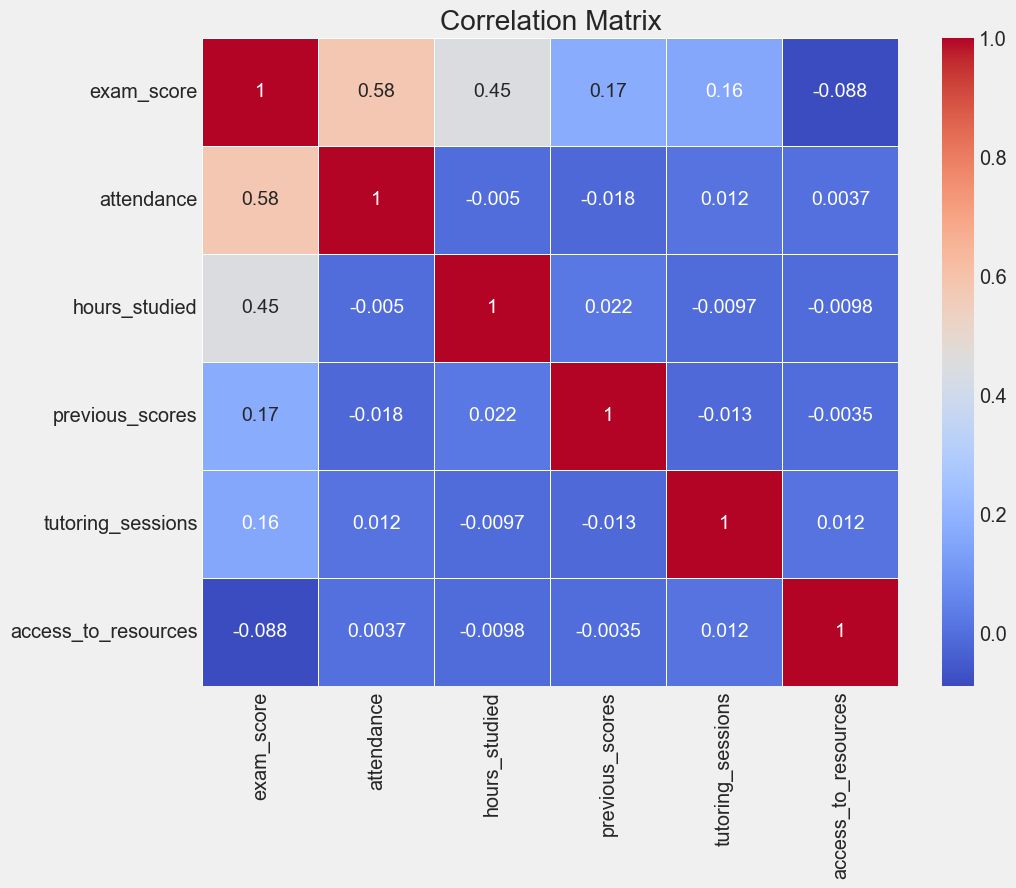

In [339]:
corr_matrix = df_fix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Linear Regression grade prediction

In [340]:
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

((5102, 20), (1276, 20))

In [341]:
categorial_features = ['parental_involvement', 'access_to_resources', 'extracurricular_activities','motivation_level','internet_access','family_income', 'teacher_quality', 'school_type', 'peer_influence', 'learning_disabilities','parental_education_level','distance_from_home','gender']
real_features = ['hours_studied', 'attendance', 'sleep_hours','previous_scores','tutoring_sessions', 'physical_activity']
target_feature='exam_score'

In [342]:
encoder = OneHotEncoder(drop='first',sparse_output=False)  # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [343]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(5102, 27)

In [344]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, train[target_feature])  # обучаем

LinearRegression()

In [345]:
test_cat = encoder.transform(test[categorial_features])
X_test = np.hstack([test[real_features], test_cat])

In [346]:
test_preds = model.predict(X_test)

In [347]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()
mean_absolute_percentage_error(test[target_feature], test_preds)


0.640900240415782

In [348]:
train_preds = model.predict(X_train)

metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5, \
metrics.mean_absolute_error(train[target_feature], train_preds), \
mean_absolute_percentage_error(train[target_feature], train_preds)

(2.088993298672602, 0.4912431489810254, 0.6683836066912411)

In [349]:
metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5, \
metrics.mean_absolute_error(test[target_feature], test_preds), \
mean_absolute_percentage_error(test[target_feature], test_preds)

(1.9706163521054707, 0.47012248642260773, 0.640900240415782)

## Random forest grade prediction

In [350]:
df = pd.read_csv("StudentPerformanceFactors.csv")
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])


In [351]:
X = df[['Attendance', 'Hours_Studied', 'Previous_Scores', 'Tutoring_Sessions', 'Access_to_Resources']]
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
mape_rf = mean_absolute_percentage_error(y_test, y_pred)

print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - R-squared: {r2_rf}')
print(f'Random Forest - MAPE: {mape_rf}')

Random Forest - Mean Squared Error: 5.8915910624059675
Random Forest - R-squared: 0.5831934308340831
Random Forest - MAPE: 1.9951747241083684


## Gradient Boosting Grade prediction using Catboost

In [352]:
df = pd.read_csv("StudentPerformanceFactors.csv")
df.columns = [x.lower() for x in df.columns]
y = df[target_feature].values
df.drop(columns=['exam_score'],inplace=True)

In [353]:
# encoder = OneHotEncoder(drop='first',sparse_output=False)  # объявляем модель
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])
# train_cat = encoder.fit_transform(df[categorial_features])  # обучаем и кодируем
# train_cat

In [354]:
# df = np.hstack([df[real_features], train_cat])
df.shape

(6607, 19)

In [355]:
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [356]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [357]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [358]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 65.3112516	test: 65.3122487	best: 65.3122487 (0)	total: 2.82ms	remaining: 279ms
1:	learn: 63.3592174	test: 63.3605728	best: 63.3605728 (1)	total: 6.63ms	remaining: 325ms
2:	learn: 61.4658123	test: 61.4671788	best: 61.4671788 (2)	total: 9.6ms	remaining: 310ms
3:	learn: 59.6295420	test: 59.6307255	best: 59.6307255 (3)	total: 11.4ms	remaining: 275ms
4:	learn: 57.8486076	test: 57.8502530	best: 57.8502530 (4)	total: 13.7ms	remaining: 260ms
5:	learn: 56.1213019	test: 56.1232596	best: 56.1232596 (5)	total: 16.6ms	remaining: 261ms
6:	learn: 54.4455349	test: 54.4455308	best: 54.4455308 (6)	total: 19ms	remaining: 252ms
7:	learn: 52.8206149	test: 52.8213488	best: 52.8213488 (7)	total: 20.5ms	remaining: 236ms
8:	learn: 51.2447008	test: 51.2449883	best: 51.2449883 (8)	total: 22.5ms	remaining: 227ms
9:	learn: 49.7164482	test: 49.7165040	best: 49.7165040 (9)	total: 25.4ms	remaining: 229ms
10:	learn: 48.2343560	test: 48.2339627	best: 48.2339627 (10)	total: 27.2ms	remaining: 220ms
11:	learn: 

{'params': {'depth': 4,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [359]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 2.14
R2: 0.71


Text(0.5, 0, 'CatBoost Feature Importance')

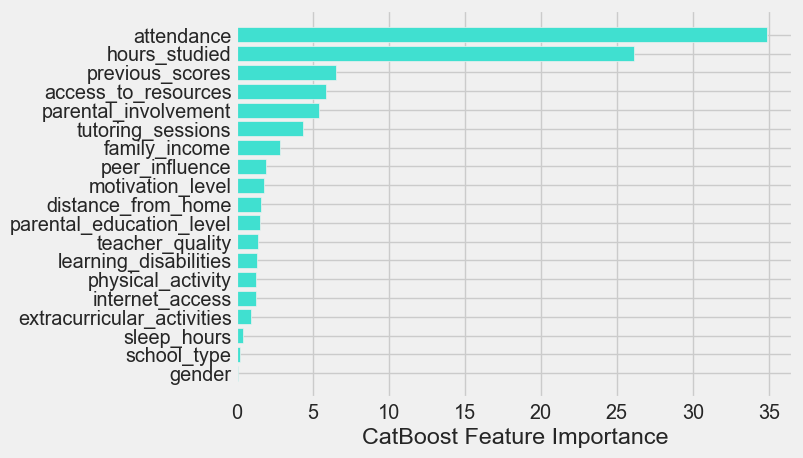

In [360]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(df.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

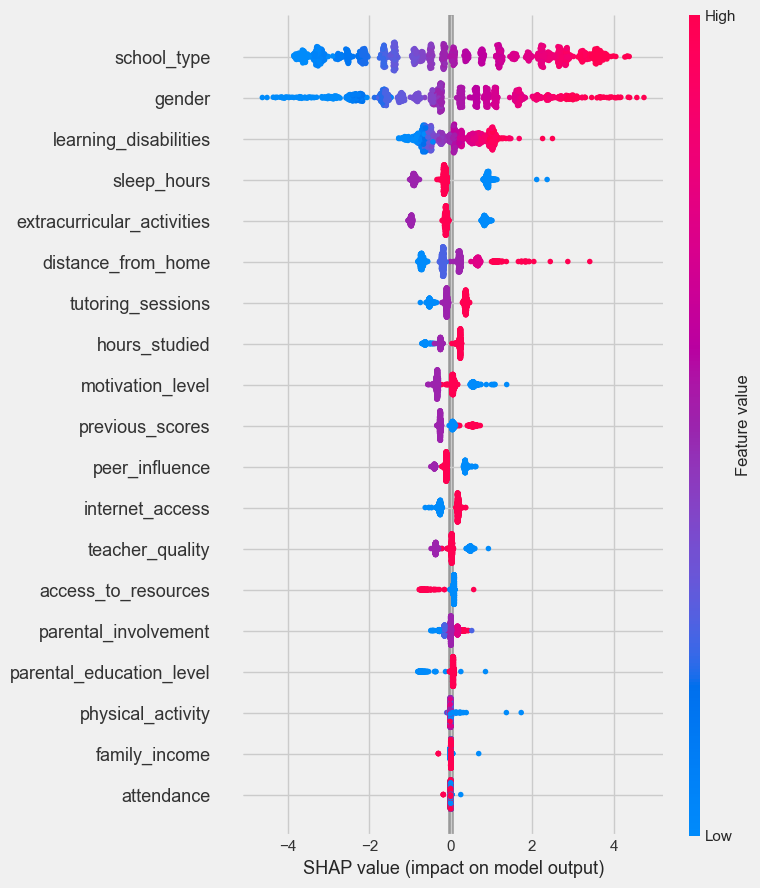

In [361]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df.columns[sorted_feature_importance])